# Running radioSphere on experimental data

In [1]:
import os, sys
import numpy
import radioSphere
import tifffile
import scipy.ndimage
import matplotlib
import matplotlib.pyplot as plt

# Plotting stuff
plt.style.use('../radioSphere/radioSphere.mplstyle')
matplotlib.rcParams['figure.figsize'] = [10,6]

ModuleNotFoundError: No module named 'radioSphere'

# Experimental parameters

In [2]:
GRAPH = False # flag to control showing all graphs within functions
verbose = True # flag to control showing extra information in this script

# Properties of the experimental setup
SOD = 23.0  # source to (middle of) object distance (mm)
SDD = 242.597 # source to detector panel distance (mm)
centreOfRotationMM = [SOD, 0., 0.]

# Detector panel properties
AVG = 4 # how much binning
pixelSizeMM = 0.127*AVG # size of one pixel on the detector panel (mm)
angle = 0 # which angle to use (this example does a full rotation in 1 degree increments)

# Particle parameters
radiusMM = 2.00/2. # measured value (mm)
nSphere  = 22

# radioSphere parameters

# optimisation parameters
pixelSizeMMatCOR = pixelSizeMM * (centreOfRotationMM[0] / SDD )
perturbationMM = numpy.array([pixelSizeMMatCOR, pixelSizeMMatCOR/4, pixelSizeMMatCOR/4])

## Calculate Beer-Lambert best fit to single particle radiograph

SOD =  24.041352445380948


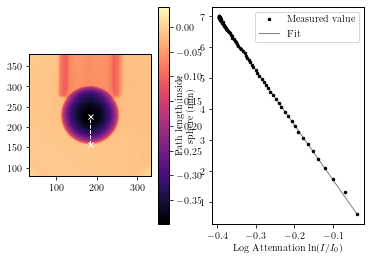

In [3]:
calibSpherePath = '../data/2021-02-09-EddyBillesNanoBis/7mm-AVG64.tif'
backgroundPath = '../data/2021-02-09-EddyBillesNanoBis/I0-AVG64.tif'
outputPath = "../cache/fit-log-linear.npy"

# Load images
calibSphere = tifffile.imread(calibSpherePath).astype(float) / tifffile.imread(backgroundPath).astype(float)
calibSphereLog = numpy.log(calibSphere)

# Projection geometry stuff
binning=4
pixelSizeMM = 0.127*float(binning)
sourceDetectorDistMM = 242.597 # from XAct
radiusMMPsi = 7/2
sourceObjectDistanceMM  = sourceDetectorDistMM * ( radiusMMPsi/71 / pixelSizeMM)     # 71 pixels across diameter, so 51um/px, pixels 0.508 mm
# uncertain parameter, this wiggles it
sourceObjectDistanceMM += 0.5
print("SOD = ", sourceObjectDistanceMM)
centreYXpx = numpy.array([ 229, 183 ])

poptN = radioSphere.calibrateAttenuation.generateFitParameters(calibSphereLog,pixelSizeMM,sourceDetectorDistMM,sourceObjectDistanceMM,radiusMMPsi,centreYXpx,outputPath=outputPath,verbose=True)

## Load and process data

Previously-made radioMM series not found, recomputing them with individual background subtraction



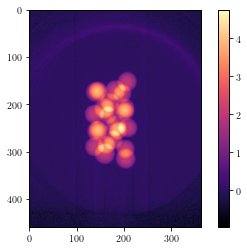

In [4]:
# load raw experimental data (first angle) and fit into mm
I  = tifffile.imread(f"../data/2021-02-09-EddyBillesNanoBis/sampleAVG{AVG:02d}/Proj/{angle:05d}.tif")
radioMask = tifffile.imread(f"../data/2021-02-09-EddyBillesNanoBis/mask.tif") > 0

# load linear fit made on 7mm sphere
def fit( x, m, c ): return m*x + c

fitParams = numpy.load("../cache/fit-log-linear.npy")

if os.path.isfile(f"../data/2021-02-09-EddyBillesNanoBis/sampleAVG{AVG:02d}/radiosMM.tif"):
    print("Loading previously-made radioMM series\n")
    radioMM = tifffile.imread(f"../data/2021-02-09-EddyBillesNanoBis/sampleAVG{AVG:02d}/radioMM.tif")
else:
    print("Previously-made radioMM series not found, recomputing them with individual background subtraction\n")
    radioMM = fit(numpy.log(tifffile.imread(f"../data/2021-02-09-EddyBillesNanoBis/sampleAVG{AVG:02d}/Proj/{angle:05d}.tif")/
                            tifffile.imread(f"../data/2021-02-09-EddyBillesNanoBis/holderAVG64/Proj/{angle:05d}.tif")), *fitParams)
    backgroundMask = numpy.logical_and(scipy.ndimage.binary_erosion(radioMM < 0.3, iterations=5), radioMask)
    background = radioSphere.computeLinearBackground(radioMM, mask=backgroundMask)

    # Apply correction to radioMM
    radioMM -= background
    #radiosMM[z] = scipy.ndimage.filters.gaussian_filter(radiosMM[z], sigma=1.5)

    tifffile.imsave(f"../data/2021-02-09-EddyBillesNanoBis/sampleAVG{AVG:02d}/radioMM.tif", radioMM.astype('<f4'))
    
plt.imshow(radioMM)
plt.colorbar()
plt.show()

## Do tomopack

In [ ]:
positionsXYZmm = radioSphere.detectSpheres.tomopackDivergentScanTo3DPositions(
    radioMM,
    radiusMM,
    CORxMin=centreOfRotationMM[0]-3,
    CORxMax=centreOfRotationMM[0]+3,
    CORxNumber=250,
    massThreshold=0.06,
    #massThreshold=0.075,
    scanFixedNumber=nSphere,
    sourceDetectorDistMM=sourceDetectorDistMM,
    pixelSizeMM=pixelSizeMM,
    l=0.2,
#     useCache=True,
#     cacheFile=f'../cache/fXseriesEXP_{angle:05d}.tif',
    maxIterations=500
    )

# Now generate a radiograph using the recovered positions
p_f_x = radioSphere.projectSphere.projectSphereMM(
    positionsXYZmm,
    radiusMM*numpy.ones(len(positionsXYZmm)),
    sourceDetectorDistMM=sourceDetectorDistMM,
    pixelSizeMM=pixelSizeMM,
    detectorResolution=radioMM.shape
    )

# Calculate the current residual (difference between what we wanted and what we got)
residual = p_f_x - radioMM

if verbose:
    plt.clf()
    plt.subplot(1,3,1)
    plt.title("radioMM")
    plt.imshow(radioMM)
    plt.colorbar()

    plt.subplot(1,3,2)
    plt.title("Guess at radioMM")
    plt.imshow(p_f_x)
    plt.colorbar()

    plt.subplot(1,3,3)
    plt.title("Residual from tomopack scan")
    plt.imshow(residual, vmin=-1, vmax=1, cmap='coolwarm')
    plt.colorbar()

    plt.show()


Output directory: 
	/Users/bmar5496/code/radioSphere/examples

No input fx and psi series found. Computing them now using 12 cores


  0% (0 of 250) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--Process SpawnPoolWorker-1:
Process SpawnPoolWorker-4:
Traceback (most recent call last):
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'computeOneCOR' on <module 'radioSphere.detectSpheres' from '/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/site-packages/radioSphere-1.0.1-py3.9-macosx-10.9-x86_64.egg/radioSphere/detectSpheres.py'>
Traceback (most recent call last):


Process SpawnPoolWorker-14:
Traceback (most recent call last):
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'computeOneCOR' on <module 'radioSphere.detectSpheres' from '/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/site-packages/radioSphere-1.0.1-py3.9-macosx-10.9-x86_64.egg/radioSphere/detectSpheres.py'>
Process SpawnPoolWorker-13:
Traceback (most recent call last):
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing

Process SpawnPoolWorker-28:
Traceback (most recent call last):
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'computeOneCOR' on <module 'radioSphere.detectSpheres' from '/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/site-packages/radioSphere-1.0.1-py3.9-macosx-10.9-x86_64.egg/radioSphere/detectSpheres.py'>
Process SpawnPoolWorker-26:
Traceback (most recent call last):
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing

Process SpawnPoolWorker-37:
Process SpawnPoolWorker-39:
Traceback (most recent call last):
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'computeOneCOR' on <module 'radioSphere.detectSpheres' from '/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/site-packages/radioSphere-1.0.1-py3.9-macosx-10.9-x86_64.egg/radioSphere/detectSpheres.py'>
Traceback (most recent call last):
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing

Process SpawnPoolWorker-48:
Traceback (most recent call last):
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'computeOneCOR' on <module 'radioSphere.detectSpheres' from '/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/site-packages/radioSphere-1.0.1-py3.9-macosx-10.9-x86_64.egg/radioSphere/detectSpheres.py'>
Process SpawnPoolWorker-50:
Traceback (most recent call last):
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing

Process SpawnPoolWorker-60:
Traceback (most recent call last):
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'computeOneCOR' on <module 'radioSphere.detectSpheres' from '/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/site-packages/radioSphere-1.0.1-py3.9-macosx-10.9-x86_64.egg/radioSphere/detectSpheres.py'>
Process SpawnPoolWorker-61:
Traceback (most recent call last):
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing

Process SpawnPoolWorker-72:
Traceback (most recent call last):
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'computeOneCOR' on <module 'radioSphere.detectSpheres' from '/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/site-packages/radioSphere-1.0.1-py3.9-macosx-10.9-x86_64.egg/radioSphere/detectSpheres.py'>
Process SpawnPoolWorker-73:
Traceback (most recent call last):
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing

Process SpawnPoolWorker-84:
Traceback (most recent call last):
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'computeOneCOR' on <module 'radioSphere.detectSpheres' from '/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/site-packages/radioSphere-1.0.1-py3.9-macosx-10.9-x86_64.egg/radioSphere/detectSpheres.py'>
Process SpawnPoolWorker-86:
Traceback (most recent call last):
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing

Process SpawnPoolWorker-96:
Traceback (most recent call last):
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'computeOneCOR' on <module 'radioSphere.detectSpheres' from '/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/site-packages/radioSphere-1.0.1-py3.9-macosx-10.9-x86_64.egg/radioSphere/detectSpheres.py'>
Process SpawnPoolWorker-100:
Process SpawnPoolWorker-97:
Traceback (most recent call last):
  File "/Users/bmar5496/anaconda3/envs/python39/

Process SpawnPoolWorker-108:
Traceback (most recent call last):
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'computeOneCOR' on <module 'radioSphere.detectSpheres' from '/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/site-packages/radioSphere-1.0.1-py3.9-macosx-10.9-x86_64.egg/radioSphere/detectSpheres.py'>
Process SpawnPoolWorker-109:
Traceback (most recent call last):
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessi

Process SpawnPoolWorker-120:
Traceback (most recent call last):
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'computeOneCOR' on <module 'radioSphere.detectSpheres' from '/Users/bmar5496/anaconda3/envs/python39/lib/python3.9/site-packages/radioSphere-1.0.1-py3.9-macosx-10.9-x86_64.egg/radioSphere/detectSpheres.py'>


## Optimise

In [ ]:
positionsXYZmmOpt = radioSphere.optimisePositions.optimiseSensitivityFields(
    radioMM,
    positionsXYZmm,
    radiusMM*numpy.ones(len(positionsXYZmm)),
    perturbationMM=perturbationMM,
    minDeltaMM=0.001,
    iterationsMax=2500,
    sourceDetectorDistMM=sourceDetectorDistMM,
    pixelSizeMM=pixelSizeMM,
    detectorResolution=I.shape,
    verbose=verbose,
    DEMcorr=False,
    GRAPH=GRAPH
    )

# Make guess at radiograph from optimised positions
p_f_x_Opt = radioSphere.projectSphere.projectSphereMM(
    positionsXYZmmOpt,
    radiusMM*numpy.ones(len(positionsXYZmmOpt)),
    sourceDetectorDistMM=sourceDetectorDistMM,
    pixelSizeMM=pixelSizeMM,
    detectorResolution=radioMM.shape
    )

# Calculate updated residual
residualOpt = p_f_x_Opt - radioMM

if verbose:
    plt.clf()
    plt.subplot(2,2,1)
    plt.title("radioMM")
    plt.imshow(radioMM)
    plt.colorbar()

    plt.subplot(2,2,2)
    plt.title("Residual from tomopack $\psi$ scan 3D guess")
    plt.imshow(residual, vmin=-1, vmax=1, cmap='coolwarm')
    plt.colorbar()

    plt.subplot(2,2,3)
    plt.title("Residual after optimisation")
    plt.imshow(residualOpt, vmin=-1, vmax=1, cmap='coolwarm')
    plt.colorbar()

    plt.subplot(2,2,4)
    plt.title(r"Residual after optimisation ($\frac{1}{50}$ LUT range)")
    plt.imshow(residualOpt, vmin=-0.02, vmax=0.02, cmap='coolwarm')
    plt.colorbar()
    plt.show()